In [12]:
import mne
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pointbiserialr
import math
import csv
import statistics
from mnelab.io import read_raw
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks, peak_prominences, peak_widths

import scipy.interpolate
from scipy import signal
from matplotlib import patches
import pyxdf

In [82]:
def calculate_EI (epoch, bands):
    '''
    Calculate the EI for each epoch and return a list of EI values.

    Parameters:
    -----------
    epoch : mne.epochs.Epochs
            Epochs object containing the data.
    bands : dictionary
            Dictionary containing the bands' names and their limits.
            Example: bands = {'theta': (4,8), 'alpha': (8, 12), 'beta': (12, 30)}

    Returns:
    --------
    ei : list
            List of EI values for each epoch.

    To calculate the EI:
    The function first calculates the PSD for each epoch,
    then averages the PSD over all electrodes and then averages the PSD over the
    frequencies in the band of interest. 
    The EI is then calculated by dividing the average PSD of the beta band by 
    the sum of the average PSD of the theta and alpha bands.'''
    
    avg_bands = {}
    for band_name, band_limits in bands.items():
        low, high = band_limits
        n_fft = int(0.25 * epoch.info['sfreq'])  # 0.25 Hz resolution
        n_overlap = int(0.1 * n_fft)  # 10% overlap
        psds = epoch.compute_psd(method='welch', fmin=low, fmax=high, n_fft = n_fft, 
                                 n_overlap = n_overlap, picks = 'all')
        # print shape
        print(psds.get_data(picks = 'all').shape)
        avg_over_electrodes = psds.get_data(picks = 'all').mean(1)
        print(avg_over_electrodes.shape)
        avg_over_band = avg_over_electrodes.mean(1)
        avg_bands[band_name] = avg_over_band.tolist()
        # print(avg_bands[band_name])
    
    sum_lists = np.add(avg_bands['theta'], avg_bands['alpha'])
    ei = np.divide(avg_bands['beta'], sum_lists)
    # ei_mid = signal.medfilt(ei, kernel_size=3)
    return ei, avg_bands['alpha'], avg_bands['beta'], avg_bands['theta']

In [3]:
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma: numpy array
          the exponentially weighted moving average
    '''
    # Coerce x to an array
    x = np.array(x)
    n = x.size

    # Create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha)
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])

    # Create the weight matrix
    w = np.tril(w0**p,0)

    # Calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

In [120]:
window = 4
overlap = 0
participant = 1
bands = {'theta': (4,8), 'alpha': (8, 12), 'beta': (12, 30)}
# channels = ['F7', 'F3', 'Fz', 'F4', 'F8', 'O1', 'O2', 'Oz']
channels = ['4', '5', '1', '3', '20', '21', '2']

In [218]:
path = 'C:/Users/hilas/OneDrive/UT/results_exp_2'

Import data

In [220]:
path_calib = path + '/calib2.xdf'
path_exp = path + '/exp2.xdf'
raw_calib = read_raw(path_calib, stream_ids=[2], preload=True)
raw_exp = read_raw(path_exp, stream_ids=[2], preload=True)
# streams, header = pyxdf.load_xdf(path_calib)
# print(streams[1]['info']['name'][0])

Creating RawArray with float64 data, n_channels=24, n_times=274651
    Range : 0 ... 274650 =      0.000 ...   536.426 secs
Ready.
Creating RawArray with float64 data, n_channels=24, n_times=1598456
    Range : 0 ... 1598455 =      0.000 ...  3121.982 secs
Ready.


In [221]:
# filter data
mne.filter.filter_data(raw_calib._data, raw_calib.info['sfreq'], l_freq=0.5, h_freq=30, verbose=True)
mne.filter.filter_data(raw_exp._data, raw_exp.info['sfreq'], l_freq=0.5, h_freq=30, verbose=True)

Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.7s finished


array([[-5.26176867e-18,  3.89911686e-06,  7.56019408e-06, ...,
        -7.47794221e-07, -4.54459443e-07, -5.38035328e-18],
       [ 7.21672071e-19, -9.70074218e-07, -1.85528713e-06, ...,
         1.97189128e-06,  1.00511690e-06, -3.80317793e-19],
       [-4.61124736e-18, -4.67007244e-07, -9.18055699e-07, ...,
         9.38209908e-07,  4.19462946e-07, -4.17417836e-18],
       ...,
       [-3.48299948e-18,  5.96994475e-06,  1.14702436e-05, ...,
        -1.37639636e-05, -7.08120456e-06, -2.96800345e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.89945853e-10,  3.91082722e-10,  3.86535248e-10, ...,
         4.00177669e-10,  4.89308150e-10,  5.22049959e-10]])

Calculate EI

In [222]:
#markers
markers_calib = raw_calib.annotations
markers_exp = raw_exp.annotations

onsets_calib = markers_calib.onset
onsets_exp = markers_exp.onset

# types
types_calib = markers_calib.description
types_exp = markers_exp.description

# changes time stamps to the closeset 5 second epoch divided by window size
# calib
onsets_calib = [int(onset) // window * window for onset in onsets_calib] 
onsets_calib_new = [x / window for x in onsets_calib]

# exp
onsets_exp = [int(onset) // window * window for onset in onsets_exp]
onsets_exp_new = [x / window for x in onsets_exp]

types_calib = [x[:-2] for x in types_calib]
types_exp = [x[:-2] for x in types_exp]


In [223]:
# print channel names
print(raw_calib.ch_names)

# save channel names as a list
channel_names = raw_calib.ch_names

# list of numbers from 0 to 23
channel_numbers = list(range(0,24))
# transform numbers to strings
channel_numbers = [str(i) for i in channel_numbers]

# create a dictionary with channel names as keys and channel numbers as values
channel_dict = dict(zip(channel_names, channel_numbers))

# rename channels to  0 to 23
raw_calib.rename_channels(channel_dict)

# print channel names now
print(raw_calib.ch_names)



['EE225-000000-000758-02-DESKTOP-8G8988B_0', 'EE225-000000-000758-02-DESKTOP-8G8988B_1', 'EE225-000000-000758-02-DESKTOP-8G8988B_2', 'EE225-000000-000758-02-DESKTOP-8G8988B_3', 'EE225-000000-000758-02-DESKTOP-8G8988B_4', 'EE225-000000-000758-02-DESKTOP-8G8988B_5', 'EE225-000000-000758-02-DESKTOP-8G8988B_6', 'EE225-000000-000758-02-DESKTOP-8G8988B_7', 'EE225-000000-000758-02-DESKTOP-8G8988B_8', 'EE225-000000-000758-02-DESKTOP-8G8988B_9', 'EE225-000000-000758-02-DESKTOP-8G8988B_10', 'EE225-000000-000758-02-DESKTOP-8G8988B_11', 'EE225-000000-000758-02-DESKTOP-8G8988B_12', 'EE225-000000-000758-02-DESKTOP-8G8988B_13', 'EE225-000000-000758-02-DESKTOP-8G8988B_14', 'EE225-000000-000758-02-DESKTOP-8G8988B_15', 'EE225-000000-000758-02-DESKTOP-8G8988B_16', 'EE225-000000-000758-02-DESKTOP-8G8988B_17', 'EE225-000000-000758-02-DESKTOP-8G8988B_18', 'EE225-000000-000758-02-DESKTOP-8G8988B_19', 'EE225-000000-000758-02-DESKTOP-8G8988B_20', 'EE225-000000-000758-02-DESKTOP-8G8988B_21', 'EE225-000000-00075

In [224]:
# do the same for the exp channel names
# print channel names
print(raw_exp.ch_names)

# save channel names as a list
channel_names = raw_exp.ch_names

# list of numbers from 0 to 23
channel_numbers = list(range(0,24))
# transform numbers to strings
channel_numbers = [str(i) for i in channel_numbers]

# create a dictionary with channel names as keys and channel numbers as values
channel_dict = dict(zip(channel_names, channel_numbers))

# rename channels to  0 to 23
raw_exp.rename_channels(channel_dict)

# print channel names now
print(raw_exp.ch_names)

['EE225-000000-000758-02-DESKTOP-8G8988B_0', 'EE225-000000-000758-02-DESKTOP-8G8988B_1', 'EE225-000000-000758-02-DESKTOP-8G8988B_2', 'EE225-000000-000758-02-DESKTOP-8G8988B_3', 'EE225-000000-000758-02-DESKTOP-8G8988B_4', 'EE225-000000-000758-02-DESKTOP-8G8988B_5', 'EE225-000000-000758-02-DESKTOP-8G8988B_6', 'EE225-000000-000758-02-DESKTOP-8G8988B_7', 'EE225-000000-000758-02-DESKTOP-8G8988B_8', 'EE225-000000-000758-02-DESKTOP-8G8988B_9', 'EE225-000000-000758-02-DESKTOP-8G8988B_10', 'EE225-000000-000758-02-DESKTOP-8G8988B_11', 'EE225-000000-000758-02-DESKTOP-8G8988B_12', 'EE225-000000-000758-02-DESKTOP-8G8988B_13', 'EE225-000000-000758-02-DESKTOP-8G8988B_14', 'EE225-000000-000758-02-DESKTOP-8G8988B_15', 'EE225-000000-000758-02-DESKTOP-8G8988B_16', 'EE225-000000-000758-02-DESKTOP-8G8988B_17', 'EE225-000000-000758-02-DESKTOP-8G8988B_18', 'EE225-000000-000758-02-DESKTOP-8G8988B_19', 'EE225-000000-000758-02-DESKTOP-8G8988B_20', 'EE225-000000-000758-02-DESKTOP-8G8988B_21', 'EE225-000000-00075

In [225]:
# pick channels
raw_calib.pick_channels(channels)
raw_exp.pick_channels(channels)

# make epochs of 4 seconds with no overlap
epochs_calib = mne.make_fixed_length_epochs(raw_calib, duration=window, overlap=0)
epochs_exp = mne.make_fixed_length_epochs(raw_exp, duration=window, overlap=0)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\hilas\AppData\Local\Temp\ipykernel_22188\3753436835.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_calib.pick_channels(channels)
C:\Users\hilas\AppData\Local\Temp\ipykernel_22188\3753436835.py:3: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_exp.pick_channels(channels)


Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
780 matching events found
No baseline correction applied
0 projection items activated


In [226]:
# calculate EI for each epoch
ei_calib, alpha_calib, beta_calib, theta_calib = calculate_EI(epochs_calib, bands)
ei_exp, alpha_exp, beta_exp, theta_exp = calculate_EI(epochs_exp, bands)


Using data from preloaded Raw for 134 events and 2048 original time points ...


0 bad epochs dropped
Effective window size : 0.248 (s)
(134, 7, 1)
(134, 1)
Using data from preloaded Raw for 134 events and 2048 original time points ...
Effective window size : 0.248 (s)
(134, 7, 1)
(134, 1)
Using data from preloaded Raw for 134 events and 2048 original time points ...
Effective window size : 0.248 (s)
(134, 7, 5)
(134, 5)
Using data from preloaded Raw for 780 events and 2048 original time points ...
0 bad epochs dropped
Effective window size : 0.248 (s)
(780, 7, 1)
(780, 1)
Using data from preloaded Raw for 780 events and 2048 original time points ...
Effective window size : 0.248 (s)
(780, 7, 1)
(780, 1)
Using data from preloaded Raw for 780 events and 2048 original time points ...
Effective window size : 0.248 (s)
(780, 7, 5)
(780, 5)


In [227]:
# median filtering
ei_mid_calib = scipy.ndimage.median_filter(ei_calib, size = 3)
ei_mid_exp = scipy.ndimage.median_filter(ei_exp, size = 3)

# EWMA
ewma_calib = ewma(ei_calib, 0.2)
ewma_exp = ewma(ei_exp, 0.2)

#normalize
min_ei_calib = min(ewma_calib)
max_ei_calib = max(ewma_calib)
ei_calib_norm = [((x-min_ei_calib)/(max_ei_calib-min_ei_calib))*100 for x in ewma_calib]

min_ei = min(min_ei_calib, min(ewma_exp))
max_ei = max(max_ei_calib, max(ewma_exp))
ei_exp_norm = [((x-min_ei)/(max_ei-min_ei))*100 for x in ewma_exp]

Plot calibration and experiment

In [228]:

colors_calib = {'0': 'r', '99': 'g', '100': 'b', '200': 'pink'}
colors_pilot = {'0': 'r', '1': 'g', '2': 'b', '3': 'pink', '4': 'teal', '5': 'darkorchid', '6': 'orange', '7': 'magenta', '8': 'yellow', '9': 'cyan'}


In [186]:
print(types_calib)

['0', '99', '100', '200', '0']


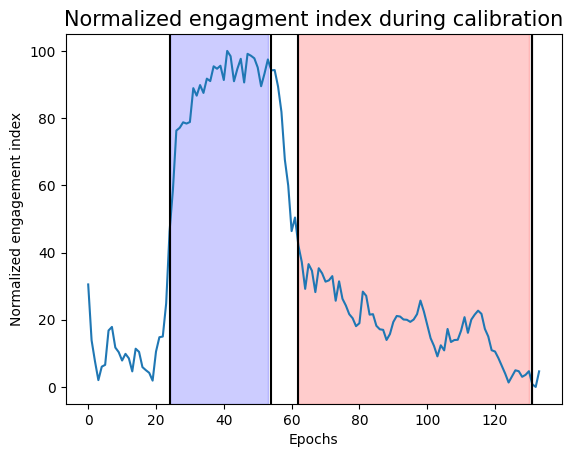

In [229]:
# find the index of the 0 event
index_0 = types_calib.index('0')
x1 = np.arange(onsets_calib_new[index_0], onsets_calib_new[index_0+1])
#position = (onsets_calib_new[index_0] + onsets_calib_new[index_0]) / 2
color_fill = 'blue'
color_fill_2 = 'red'

# find the index of the 0 event
index_100 = types_calib.index('100')
x2 = np.arange(onsets_calib_new[index_100], onsets_calib_new[index_100+1])



color_fill = 'blue'
color_fill_2 = 'red'

fig, ax = plt.subplots()
ax.plot(ei_calib_norm, label='calibration')
plt.xlabel('Epochs')
plt.ylabel('Normalized engagement index')
for onset, type in zip(onsets_calib_new, types_calib):
    ax.axvline(x=onset, color="black")
    #ax.text(onset, 0, print_type, rotation=90)
plt.title('Normalized engagment index during calibration', fontsize=15)
ax.fill_between(x1, 0, 1 ,
    color=color_fill, alpha = 0.2, transform=ax.get_xaxis_transform())

ax.fill_between(x2, 0, 1 ,
    color=color_fill_2, alpha = 0.2, transform=ax.get_xaxis_transform())
plt.show()

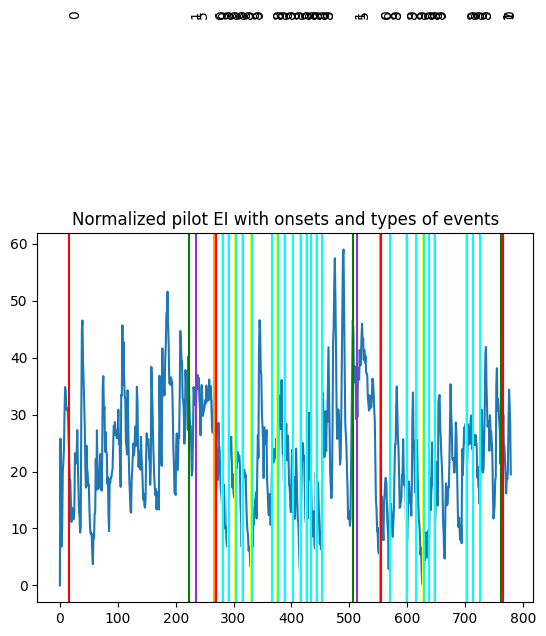

In [230]:
fig, ax = plt.subplots()
ax.plot(ei_exp_norm, label='pilot')
for onset, type in zip(onsets_exp_new, types_exp):
    ax.axvline(x=onset, color=colors_pilot[type])
    ax.text(onset, 100, type, rotation=90)
plt.title('Normalized pilot EI with onsets and types of events')
plt.show()

In [231]:
# types pilot to list
# types_exp = [x[:-2] for x in types_exp]
first_video = int(onsets_exp_new[types_exp.index('0')])


#load ei results from csv file as a pandas dataframe
fname = 'C:/Users/hilas/OneDrive/UT/EEG-BCI-Hila_thesis/EEG_BCI_final_project/Results/ei_realtime_13-12-2023_14-33-08.csv'

#p3
#fname = 'C:/Users/hilas/OneDrive/UT/EEG-BCI-Hila_thesis/EEG_BCI_final_project/Results/ei_realtime_14-12-2023_10-24-03.csv'

#p4
#fname = 'C:/Users/hilas/OneDrive/UT/EEG-BCI-Hila_thesis/EEG_BCI_final_project/Results/ei_realtime_14-12-2023_14-31-31.csv'


df = pd.read_csv(fname, sep=',', header=None)

# # convert df norm column to a list
ei_norm = df[3].tolist()
# ei_raw = df[0].tolist()[1::]
# # convert the raw scores to float
# ei_raw = [float(x) for x in ei_raw]

colors_pilot = {'0': 'r', '1': 'g', '2': 'b', '3': 'pink', '4': 'teal', '5': 'darkorchid', '6': 'orange', '7': 'magenta', '8': 'yellow', '9': 'cyan'}


# my_file = open('./Results/ei_avg_1.txt', 'r')
# data = my_file.readlines()
# # remove the \n from the end of the string
# data = [x[:-1] for x in data]
# #convert to int
avg_ei = [int(x) for x in ei_norm[1::]]

# plot normalized pilot EI including onests of events and types of events




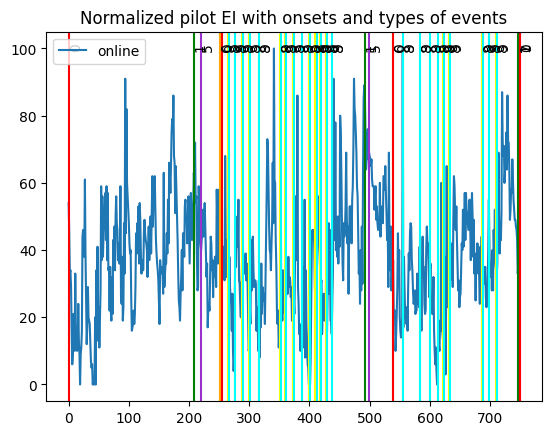

In [232]:
fig, ax = plt.subplots()
# ax.plot(ei_norm_pilot[first_video:], label='offline', color='black')
ax.plot(avg_ei, label='online')
#mark every third point with a dot
x = np.arange(2, len(avg_ei), 3)
# ax.plot(x, avg_ei[2::3], 'o', color='red')
for onset, type in zip(onsets_exp_new, types_exp):
    ax.axvline(x=onset-first_video, color=colors_pilot[type])
    ax.text(onset-first_video, 100, type, rotation=90)
plt.title('Normalized pilot EI with onsets and types of events')
ax.legend()
plt.show()

# # save figure
# fig.savefig('./Results/ei_avg_1.png', dpi=300)


In [102]:
print(types_exp)

['0', '1', '5', '6', '0', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '1', '5', '6', '0', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '8', '9', '1', '7', '0']


In [233]:
conditions_start = [i for i, x in enumerate(types_exp) if x == '0']
conditions_end = [i for i, x in enumerate(types_exp) if x == '1']


for i in range(len(conditions_end)):
    start = conditions_start[i]
    end = conditions_end[i]

    if i == 0:
        ei_exp_1 = ei_exp_norm[int(onsets_exp_new[start]):int(onsets_exp_new[end])]
    if i == 1:
        ei_exp_2 = ei_exp_norm[int(onsets_exp_new[start]):int(onsets_exp_new[end])]
    if i == 2:
        ei_exp_3 = ei_exp_norm[int(onsets_exp_new[start]):int(onsets_exp_new[end])]


ei_exp_all = ei_exp_1 + ei_exp_2 + ei_exp_3
order = ['1'] * len(ei_exp_1) + ['2'] * len(ei_exp_2) + ['3'] * len(ei_exp_3)
participant = ['2'] * len(ei_exp_all)

df_offline = pd.DataFrame({'EI_offline': ei_exp_all, 'order': order, 'participant': participant})

# save df to file
path = 'C:/Users/hilas/OneDrive/UT/EEG-BCI-Hila_thesis/EEG_BCI_final_project/Results/ei_exp_p2.csv'
df_offline.to_csv(path, index=False)

In [166]:
conditions_start

[0, 4, 36, 57]

In [216]:
# save the online EI values to file

# first make new onsets, subtracting the first video
onsets_exp_new_online = [x - first_video for x in onsets_exp_new]

conditions_start = [i for i, x in enumerate(types_exp) if x == '0']
conditions_end = [i for i, x in enumerate(types_exp) if x == '1']


for i in range(len(conditions_end)):
    start = conditions_start[i]
    end = conditions_end[i]

    if i == 0:
        ei_exp_1 = avg_ei[int(onsets_exp_new_online[start]):int(onsets_exp_new_online[end])]
    if i == 1:
        ei_exp_2 = avg_ei[int(onsets_exp_new_online[start]):int(onsets_exp_new_online[end])]
    if i == 2:
        ei_exp_3 = avg_ei[int(onsets_exp_new_online[start]):int(onsets_exp_new_online[end])]


ei_exp_all_online = ei_exp_1 + ei_exp_2 + ei_exp_3


order = ['1'] * len(ei_exp_1) + ['2'] * len(ei_exp_2) + ['3'] * len(ei_exp_3)
df_online = pd.DataFrame({'EI_online': ei_exp_all_online, 'EI_offline': ei_exp_all, 'order': order, 'participant': participant})



path = 'C:/Users/hilas/OneDrive/UT/EEG-BCI-Hila_thesis/EEG_BCI_final_project/Results/ei_online_p2.csv'
df_online.to_csv(path, index=False)

In [155]:
onsets_exp_new[0]

0.0